## Trabalho final - Validação de modelos de clusterização [22E4_3] - Pedro Pinheiro Cabral

Trabalho completo no github https://github.com/ppcpedro/validacao_modelos_clust_pedro_p_infnet

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

## Escolha de base de dados

 1. & 2. A base de dados vem do kaggle https://www.kaggle.com/datasets/etsc9287/2020-general-election-polls e foi escolhida para entender relações entre preferências políticas, danos da COVID-19 e demografia de municípios dos Estados Unidos, curiosidade minha.

In [2]:
df = pd.read_csv('county_statistics.csv')

In [3]:
# Seleção de colunas para a minha análise

df = df[['percentage20_Donald_Trump', 'deaths', 'TotalPop',
       'White','IncomePerCap',
        'Poverty', 'WorkAtHome',
       'Unemployment']]

# Normalização da estatística de mortes -- as demais já são normalizadas 
# (pelo população de cada município)
df['pct_deaths'] = round((df.deaths / df.TotalPop)*100*100,1)
df['percentage20_Donald_Trump'] = df['percentage20_Donald_Trump']*100
df = df[['percentage20_Donald_Trump', 'pct_deaths',
       'White',
        'Poverty', 'WorkAtHome',
       'Unemployment','IncomePerCap']]

# As multiplicações por 100 foram apenas pra deixar no mesmo formato

In [4]:
df

,percentage20_Donald_Trump,pct_deaths,White,Poverty,WorkAtHome,Unemployment,IncomePerCap
0,66.1,6.9,68.9,22.7,6.5,9.4,19234.0
1,79.5,16.3,77.5,21.5,2.5,8.9,21591.0
2,54.2,5.8,60.3,19.8,4.5,5.4,24266.0
3,50.4,4.2,85.2,11.8,6.9,4.3,31642.0
4,69.7,1.4,96.6,9.5,6.2,3.0,28861.0
...,...,...,...,...,...,...,...
4862,NaN,NaN,70.2,7.4,3.8,7.5,37935.0
4863,NaN,NaN,64.4,11.7,8.4,7.0,29943.0
4864,NaN,NaN,43.7,6.2,4.2,6.5,32393.0
4865,NaN,NaN,21.3,25.5,8.0,19.7,21057.0


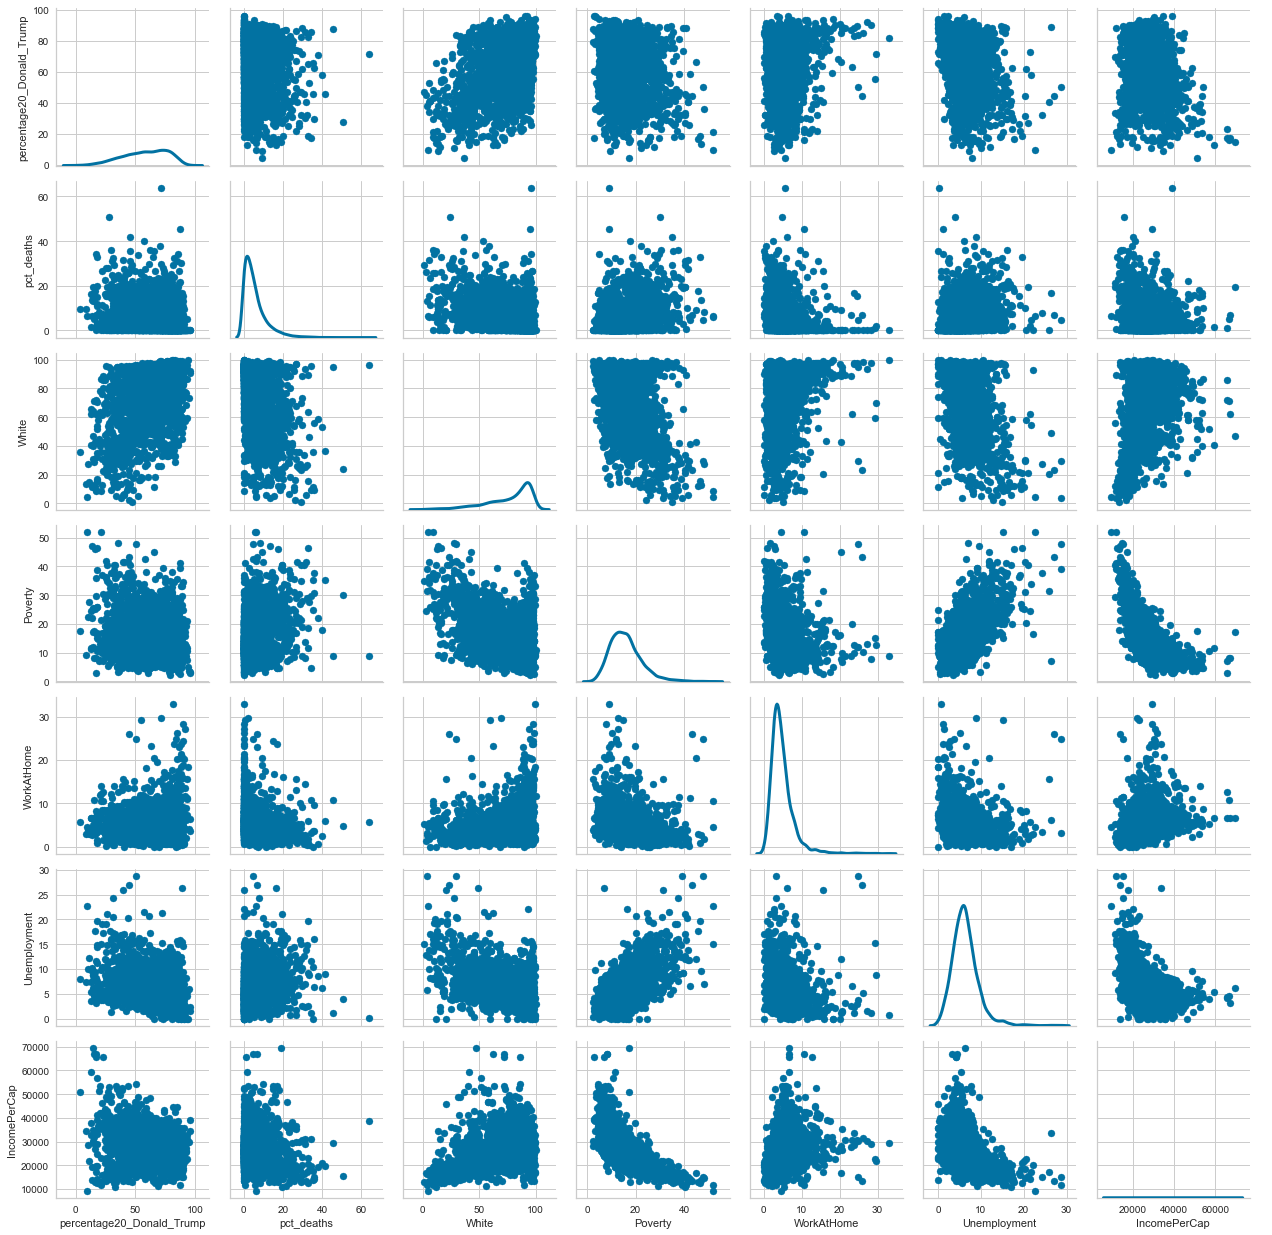

In [57]:
# Faixa dinâmica das variáveis 
g = sns.PairGrid(df, vars=df.columns)
g.map_diag(sns.kdeplot, lw=3)
g.map_offdiag(plt.scatter)
g.add_legend()

3. & 4. Os dados necessitam de remoção de NaNs, outliers e uma normalização na base inteira.

In [5]:
# Farei análise apenas quando não houver NaNs

df_study = df.dropna()
df_study

,percentage20_Donald_Trump,pct_deaths,White,Poverty,WorkAtHome,Unemployment,IncomePerCap
0,66.1,6.9,68.9,22.7,6.5,9.4,19234.0
1,79.5,16.3,77.5,21.5,2.5,8.9,21591.0
2,54.2,5.8,60.3,19.8,4.5,5.4,24266.0
3,50.4,4.2,85.2,11.8,6.9,4.3,31642.0
4,69.7,1.4,96.6,9.5,6.2,3.0,28861.0
...,...,...,...,...,...,...,...
3108,52.5,6.2,5.2,34.1,2.0,12.4,17817.0
3109,34.0,15.6,5.4,36.2,5.4,10.1,13105.0
3110,44.6,7.0,23.4,43.1,25.9,27.0,13461.0
3810,90.1,6.7,82.9,24.8,2.5,6.1,18836.0


In [6]:
# Filtro de outliers para não prejudicar a análise

df_study = df_study[df_study.lt(df_study.quantile(0.99)).all(1) \
                    & df_study.gt(df_study.quantile(0.01)).all(1)]

In [7]:
df_study

,percentage20_Donald_Trump,pct_deaths,White,Poverty,WorkAtHome,Unemployment,IncomePerCap
0,66.1,6.9,68.9,22.7,6.5,9.4,19234.0
1,79.5,16.3,77.5,21.5,2.5,8.9,21591.0
2,54.2,5.8,60.3,19.8,4.5,5.4,24266.0
3,50.4,4.2,85.2,11.8,6.9,4.3,31642.0
4,69.7,1.4,96.6,9.5,6.2,3.0,28861.0
...,...,...,...,...,...,...,...
3103,52.4,1.3,72.0,5.2,4.2,6.4,38193.0
3104,86.3,6.1,78.8,16.5,6.1,4.5,25661.0
3105,59.3,1.3,56.3,18.5,4.8,9.9,22814.0
3106,52.3,17.5,31.8,19.7,3.0,10.9,20600.0


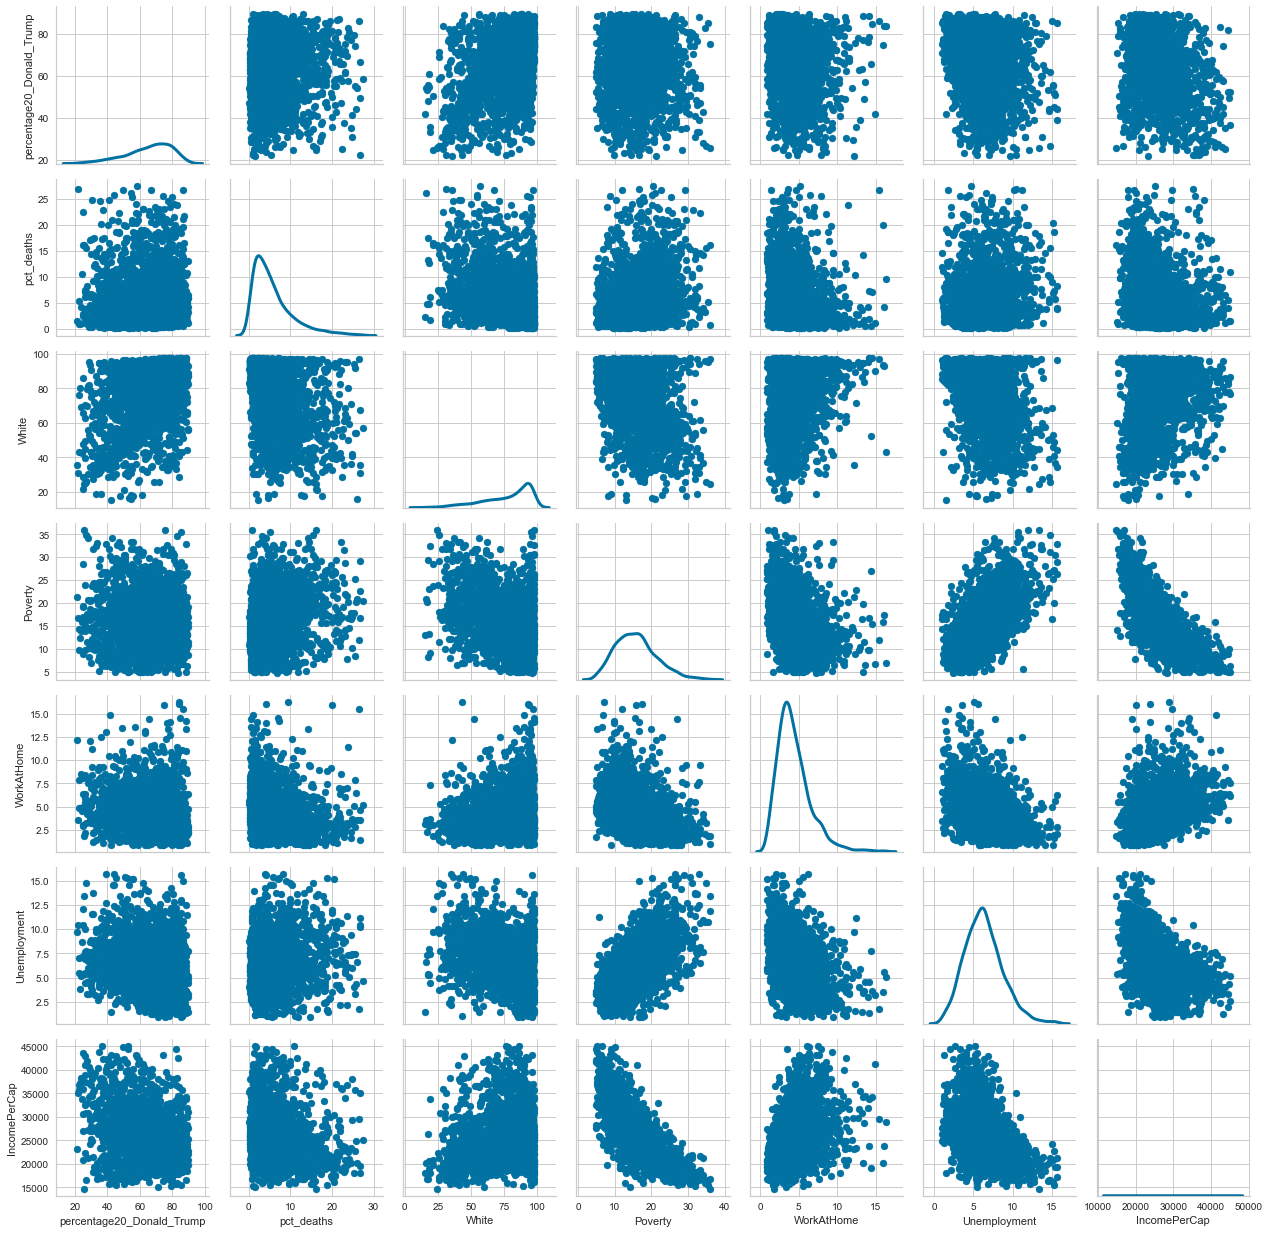

In [56]:
# Faixa dinâmica das variáveis apenas com filtros básicos
g = sns.PairGrid(df_study, vars=df_study.columns)
g.map_diag(sns.kdeplot, lw=3)
g.map_offdiag(plt.scatter)
g.add_legend()

C:\Users\pedro\anaconda3\lib\site-packages\seaborn\axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x0000025CB8CFEE50> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


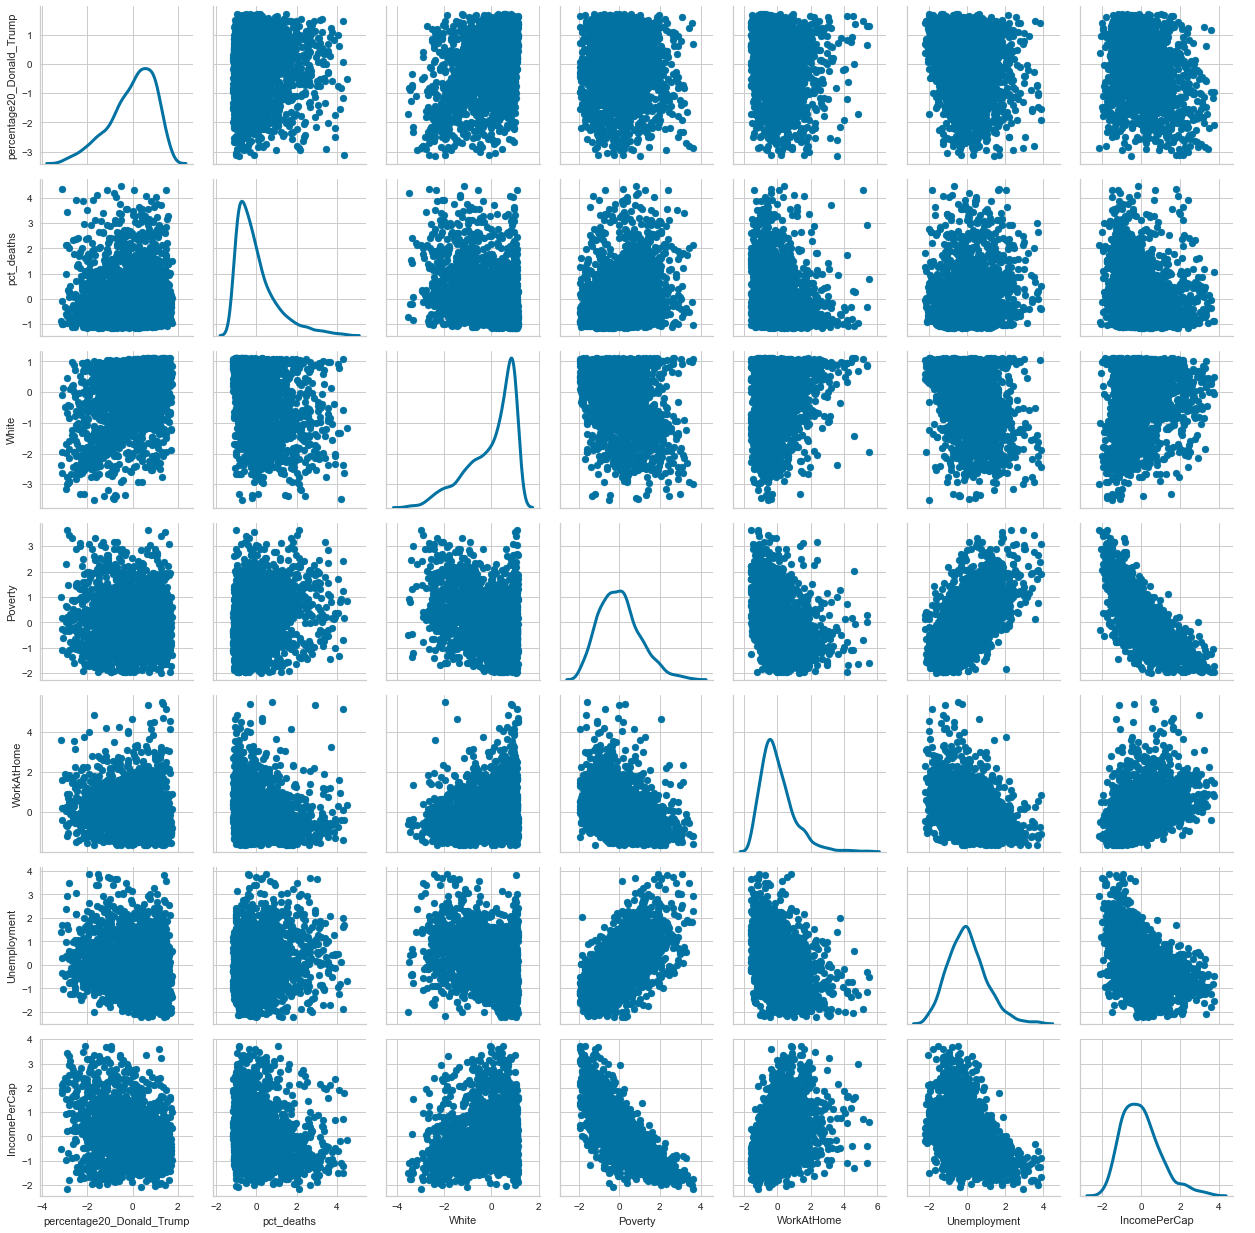

In [11]:
# Normalização total dos dados
scaler = StandardScaler()
df_quant_main_fit = scaler.fit(df_study)
df_quant_main_scaled = scaler.transform(df_study)

# Faixa dinâmica das variáveis totalmente pré-processadas
df_quant_main_scaled = pd.DataFrame(df_quant_main_scaled, columns=df_study.columns)

g = sns.PairGrid(df_quant_main_scaled, vars=df_quant_main_scaled.columns)
g.map_diag(sns.kdeplot, lw=3)
g.map_offdiag(plt.scatter)
g.add_legend()

Entendo que as distribuições são gaussianas o suficiente, rs. Só o dado étnico que é um pouco mais distorcido. Vamos prosseguir com a Silhueta.

## Clusterização

1) O Coeficiente de Silhueta é calculado usando a distância média intra-cluster (a) e a distância média do cluster diferente mais próximo (b) para cada amostra. A fórmula é (b - a) / max(a, b).

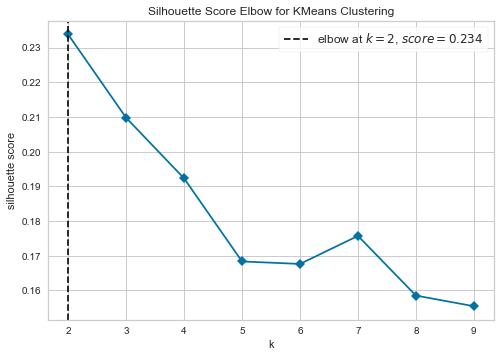

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [53]:
kmeans = KMeans()

visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='silhouette', timings=False
)

visualizer.fit(df_quant_main_scaled)        
visualizer.show()   

1) 1. Melhor score da Silhueta foi pra k=2, então vou usar isso no KMeans

In [54]:
kmeans = KMeans(n_clusters=2, random_state=42)

k_fit = kmeans.fit(df_quant_main_scaled)

clusters = k_fit.labels_
cluster_df = df_quant_main_scaled.copy()
cluster_df['cluster'] = clusters

cluster_df

,percentage20_Donald_Trump,pct_deaths,White,Poverty,WorkAtHome,Unemployment,IncomePerCap,cluster
0,0.034609,0.230126,-0.502092,1.242372,0.977073,1.272079,-1.276247,0
1,0.996749,2.169858,-0.018396,1.025837,-0.872146,1.065485,-0.820553,0
2,-0.819829,0.003136,-0.985788,0.719078,0.052463,-0.380669,-0.303379,0
3,-1.092674,-0.327031,0.414680,-0.724491,1.161995,-0.835175,1.122668,1
4,0.293094,-0.904824,1.055858,-1.139517,0.838382,-1.372318,0.585001,1
...,...,...,...,...,...,...,...,...
2502,-0.949071,-0.925459,-0.327737,-1.915436,-0.086228,0.032518,2.389214,1
2503,1.484999,0.065042,0.054720,0.123606,0.792151,-0.752538,-0.033675,1
2504,-0.453641,-0.925459,-1.210763,0.484498,0.191155,1.478672,-0.584103,0
2505,-0.956251,2.417484,-2.588733,0.701034,-0.640994,1.891859,-1.012149,0


In [16]:
cluster_df.groupby('cluster').mean().T

cluster,0,1
percentage20_Donald_Trump,0.078358,-0.065241
pct_deaths,0.387274,-0.322445
White,-0.491115,0.408904
Poverty,0.791384,-0.658908
WorkAtHome,-0.479370,0.399124
Unemployment,0.658429,-0.548209
IncomePerCap,-0.707748,0.589273


Cluster 0 e 1 tiveram resultados eleitorais similares, ligeiramente mais pendendo pro Trump no 0, e o 0 teve significativamente mais mortes por COVID, também possuem menor população branca, mais pobreza, menos home office, mais desemprego e menos renda per capita. 

Em testes com mais clusters do k-means, as diferenças eleitorais se mostram maiores, não vou mostrar em prol do seu tempo.

1) 2. O DBScan estou executando da maneira padrão.

In [59]:
dbscan =  DBSCAN()
dbscan_labels = dbscan.fit_predict(df_quant_main_scaled)

In [60]:
cluster_df['cluster_db'] = dbscan_labels

In [63]:
cluster_df[cluster_df.cluster_db <= 4].groupby('cluster_db').mean().T[:-1]

cluster_db,-1,0,1,2,3,4
percentage20_Donald_Trump,-0.008779,0.316660,-0.155152,0.173083,0.242833,0.799295
pct_deaths,0.038515,-0.628626,-0.754480,-0.769219,-0.951525,-0.600451
White,-0.042031,0.845449,0.951406,0.918061,0.768719,0.859005
Poverty,0.023986,-0.451971,-0.925560,-1.212985,0.375281,-0.129019
WorkAtHome,0.010963,-0.447774,0.990282,0.432214,-0.453639,-0.282708
Unemployment,0.018398,-0.203741,-1.230654,-1.180481,0.360893,0.135814
IncomePerCap,-0.008487,0.019235,0.377661,0.700712,-0.370365,-0.182592


In [62]:
cluster_df[cluster_df.cluster_db > 4].groupby('cluster_db').mean().T[:-1]

cluster_db,5,6,7,8,9,10
percentage20_Donald_Trump,-0.355512,0.515679,-0.452205,-0.412355,0.015120,0.883303
pct_deaths,-0.609049,-1.021758,-0.875934,-0.693310,-0.822282,-0.892442
White,0.529511,0.949933,0.682400,0.756360,0.892751,0.995115
Poverty,-1.083880,-0.116989,-0.648704,-0.507956,-1.237474,0.982530
WorkAtHome,-0.221067,-0.771980,-0.234166,-0.456072,-0.066415,-0.234166
Unemployment,-0.718105,-0.043233,-0.620318,-0.370340,-1.183433,0.710144
IncomePerCap,0.699536,-0.239933,0.383622,0.818454,0.988990,-0.852802


2) Muito mais clusters no DBScan do que a Silhueta encontrou pro KMeans. Com eps em 0.4 pra baixo não encontra nenhum cluster.

Potencialmente existem clusters não convexos que a silhueta não conseguiu detectar.

Sinceramente, como é uma base, mesmo após os filtros, de mais de 2000 cidades americanas, é de se esperar sim um bom número de clusters. Achei o DBScan fazendo mais sentido aqui.

3) Testando a métrica do cotovelo ou distorção:

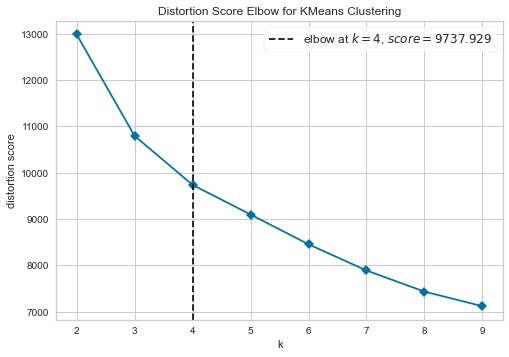

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
kmeans = KMeans()

visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='distortion', timings=False
)

visualizer.fit(df_quant_main_scaled)        
visualizer.show()   


Testando a métrica de Calinski-Harabasz:

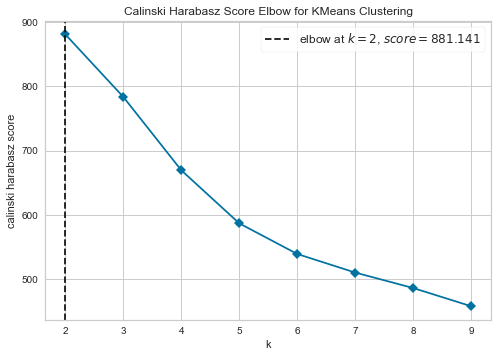

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [55]:
kmeans = KMeans()

visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='calinski_harabasz', timings=False
)

visualizer.fit(df_quant_main_scaled)        
visualizer.show()   

4) Então, o DBScan não foi feito exatamente para usar um número pré-determinado de clusters, mas sim de parâmetros como o eps e o min_samples, que determinarão a evolução do algoritmo. Ainda assim, a Silhueta pode sim dar um bom 'cheiro' do número de clusters a se esperar do DBScan, exceto se houverem clusters não convexos. Então a resposta é sim, mas com cautela.

# Medidas de similaridade

1) 
1- Primeiramente, precisamos construir as curvas de correlação cruzada: precisamos usar todos os pares possíveis de 2 curvas e calcular a correlação (pode ser a de Pearson mesmo) em todos os 'lags' possíveis, atrasando uma curva em relação a outra de todas as maneiras possíveis e razoáveis (com muito poucos pontos podem haver resultados insignificantes), e encontrando os valores máximo de correlação cruzada para cada par de curvas;

2- Sendo assim, monta-se um dataframe mostrando tais melhores valores de correlação cruzada. Para encontrar 3 clusters, podemos jogar esse dataframe em um método de clusterização hierárquica com 3 clusters predefinidos, como o AgglomerativeClustering do sklearn, feito isso está pronto.

2) Eu iria justamente com o AgglomerativeClustering do sklearn, que me permite inclusive plotar um dendograma e ver detalhes do relacionamento entre as séries até mesmo intra-cluster.

3) Um caso poderia ser utilizando curvas de luz de estrelas, em dados como do telescópio espacial KEPLER ou TESS, e possivelmente essa clusterização nos traria um agrupamento de estrelas que possuam atividades magnéticas similares. Outro caso é o que o professor mostrou em sala de ações na bolsa de valores, de encontrar empresas que variam de maneira conjunta, até certo nível: em geral, empresas de um mesmo setor econômico dentro de um mesmo país.

4) Outra estratégia é o Dynamic Time Warping (DTW), que funciona também comparando de 2 em 2 séries, da seguinte maneira:

1- Divide as duas séries em pontos iguais. 

2- Calcula a distância euclidiana entre o primeiro ponto da primeira série e todos os pontos da segunda série. Armazena a distância mínima calculada.

3- Move para o segundo ponto e repite o passo 2. Mova passo a passo ao longo dos pontos e repete o passo 2 até esgotar todos os pontos.

4- Repete 2 e 3, mas com a segunda série como ponto de referência.

5 - Soma todas as distâncias mínimas que foram armazenadas e esta é uma verdadeira medida de similaridade entre as duas séries.